In [85]:
def powFunction(x):
  return (10*(x[0] - x[1])**2 + (x[0] - 1)**2)**4

In [51]:
powFunction([-2.22225999e-01, -3.78364743e-06])

15.608870254574194

In [243]:
import random
import sys
import numpy as np
import sympy as sp
numpy.set_printoptions(threshold=sys.maxsize)
from scipy.optimize import minimize
from sympy.matrices import Matrix
import matplotlib.pyplot as plt

In [6]:
def isLeftLower(f,x,h):
  if f(x + h) > f(x -h):
    return True
  return False

In [144]:
def findSectionEnd(f, x0, h, alpha):
  safer = 0
  hist = []
  hist.append(alpha)
  while safer<10000:
    y0 = f(x0)
    h = h*2
    x0 = x0 + h*alpha
    hist.append(alpha*2)
    if y0<f(x0):
      return x0, hist

  print("Overflow error")

In [145]:
def sven(f, x0, h, alpha):
  bufer = x0.copy()
  if isLeftLower(f, x0, h):
    return [[findSectionEnd(f, x0, h, -alpha)[0], bufer], findSectionEnd(f, x0, h, -alpha)[1]]
  return [[bufer, findSectionEnd(f, x0, h, alpha)[0]], findSectionEnd(f, x0, h, alpha)[1]]

In [235]:
def golden_section(interval, x0, S, f, eps):
    a, b = interval
    x1_gold = a + 0.382*(b - a)
    x2_gold = a + 0.618*(b - a)

    fx1_gold = f(x1_gold)
    fx2_gold = f(x2_gold)

    while True:
        if fx1_gold <= fx2_gold:
            b = x2_gold
            x2_gold = x1_gold
            x1_gold = a + 0.382*(b - a)
        else:
            a = x1_gold
            x1_gold = x2_gold
            x2_gold = a + 0.618*(b - a)
        if abs(norm(b - a)) <= eps:
            if fx1_gold < fx2_gold:
                answ = x1_gold
            else:
                answ = x2_gold
            break
        else:
          fx1_gold = f(x1_gold)
          fx2_gold = f(x2_gold)
            
    return answ

In [177]:
def dsk_paul(x0, S, f, eps, lambdas):
  x1_dsk, x2_dsk, x3_dsk = 0 ,lambdas[-2], lambdas[-1]
  fx1_dsk, fx2_dsk, fx3_dsk = f(x0 + x1_dsk), f(x0 + x2_dsk), f(x0 + x3_dsk)
  x1_dsk, x2_dsk, x3_dsk = x0 + x1_dsk ,x0 + x2_dsk, x0 + x3_dsk
  deltax_dsk = abs(norm(x1_dsk - x2_dsk))
    
  x11, x12 = Matrix(x0) + lmbd*Matrix(S)
  kvx = x2_dsk + (deltax_dsk * (fx2_dsk - fx3_dsk)) / (2*(fx1_dsk - 2*fx2_dsk + fx3_dsk))
  print(x11.subs(lmbd, kvx))
  fkvx = [f(x11.subs(lmbd, kvx), x12.subs(lmbd, kvx)])
  while True:
      if abs(fx2_dsk - fkvx) <= eps and abs(x2_dsk - kvx) <= eps:
          break
      else:
          if fkvx < fx2_dsk:
              if kvx > x2_dsk:
                  x1_dsk, x2_dsk = x2_dsk, kvx
                  fx1_dsk, fx2_dsk = fx2_dsk, fkvx
              else:
                  x2_dsk, x3_dsk = kvx, x2_dsk
                  fx2_dsk, fx3_dsk = fkvx, fx2_dsk
          else:
              if kvx > x2_dsk:
                  x3_dsk = kvx
                  fx3_dsk = fkvx
              else:
                  x1_dsk = kvx
                  fx1_dsk = fkvx
          a1 = (fx2_dsk - fx1_dsk) / (x2_dsk - x1_dsk)
          a2 = ((fx3_dsk-fx1_dsk)/(x3_dsk-x1_dsk) - (fx2_dsk-fx1_dsk)/(x2_dsk-x1_dsk)) / (x3_dsk - x2_dsk)
          kvx = (x1_dsk + x2_dsk) / 2 - (a1/(2*a2))
          fkvx = f([x11.subs(lmbd, kvx), x12.subs(lmbd, kvx)])
    # res = minimize(f, x0, method='powell',
    # options={'xtol': eps, 'disp': False})
    # return(res.direc[-1])
  return kvx

In [11]:
def find_df(f, x, i, h):
    return ( right(f, x, i, h) + left(f, x, i, h) ) / 2

def right(f, x, i, h):
    x_h = x.copy()
    x_h[i] += h
    return ( f(x_h) - f(x) ) / h
def left(f, x, i, h):
    x_h = x.copy()
    x_h[i] -= h
    return ( f(x) - f(x_h) ) / h

In [12]:
def norm(x):
    return (x[0]**2 + x[1]**2)**0.5

In [146]:
def findNear(x0, f, h_diff, alpha, eps_singleDim, searchAlgorythm):
  dfx1 = find_df(f, x0, 0, h_diff)
  dfx2 = find_df(f, x0, 1, h_diff)
  grad = np.array([[dfx1], [dfx2]])
  S0 = - grad
  X = x0.copy()
  S = S0.copy()

  if searchAlgorythm == 'g':
    interval = sven(f, X, h_diff, alpha)[0]
    return golden_section(interval, X, S, f, eps_singleDim)
  elif searchAlgorythm == 'd':
    interval, lambdas = sven(f, X, h_diff, alpha)
    return dsk_paul(x0 = X, s=S, f=f, eps = eps_singleDim, lambdas = lambdas)

In [ ]:
def randomStep(x,h):
  res = np.array([float()] * 2)
  y = random.uniform(x[1]-h[1],x[1]+h[1])
  res[1] = y
  res[0] = (1-(res[1]-x[1])**2)**0.5 + x[0]
  return res

In [340]:
def adaptiveSearch(x, h, n, R, k, func, h_diff, alpha, eps_singleDim, searchAlgorythm, max_deep, useMaxDeep, constraint):
  y0 = func(x)
  ybof = y0
  xbof = x
  for i in range(n):
    step = randomStep(x, h)
    if y0 > func(step) and constraint(step):
      dfx1 = find_df(func, x, 0, h_diff)
      dfx2 = find_df(func, x, 1, h_diff)
      grad = np.array([[dfx1], [dfx2]])
      S0 = - grad
      S = S0.copy()
      y0 = func(step)
      x = step*(1/k)
      h =np.array(h)
      h = h*k
      i=0
      max_deep = 10
  h =np.array(h)
  h = h*k
  if max_deep==0:
    return min(func(x), func(xbof))
  elif ybof - func(step) < R:
    return min(func(x), func(xbof))
  x = findNear(x0=x, f=func, h_diff=h_diff, alpha=alpha, eps_singleDim=eps_singleDim, searchAlgorythm=searchAlgorythm)
  max_deep -= 1
  plotpoints.append(min(func(x), func(xbof)))
  if func(x) > func(xbof) or not constraint(x):
    x = xbof
  return adaptiveSearch(x, h, n, R, k, func, h_diff, alpha, eps_singleDim, searchAlgorythm, max_deep, useMaxDeep=True, constraint=constraint)

def constraint(x):
  return True

[0.05947026500475894, 0.05947026496179365, 0.05947026496115295, 0.059470264961151424, 0.059470264961151424, 0.059470264961151424, 0.059470264961151424, 0.059470264961151424, 0.059470264961151424, 0.059470264961151424]


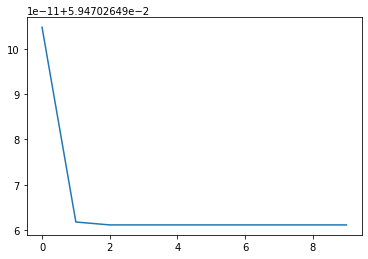

In [257]:
plotpoints = []
adaptiveSearch([-1.2,0],
               h=[1e-2,1e-2],
               n=1*10**5,
               R=1e-3,
               k=0.2,
               func= powFunction,
               h_diff = 1e-3,
               alpha = 1e-3,
               eps_singleDim = 0.0001,
               searchAlgorythm='g',
               max_deep=10)
plt.plot(plotpoints)
plt.show()

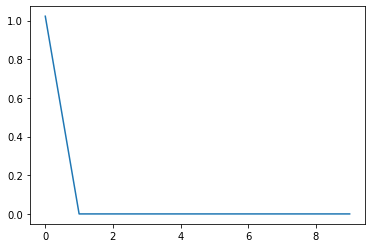

In [293]:
plotpoints = []
adaptiveSearch([-1.2,0], h=[1e-2,1e-2],
               n=1*10**5, R=1e-3, k=0.2,
               func= powFunction,h_diff = 1e-3,
               alpha = 1e-3, eps_singleDim = 0.0001,
               searchAlgorythm='d', max_deep=10)
plt.plot(plotpoints)
plt.show()

1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


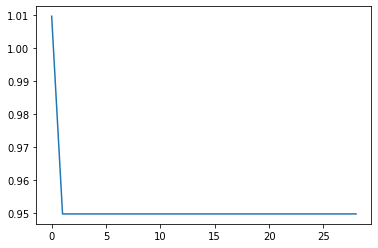

0.1


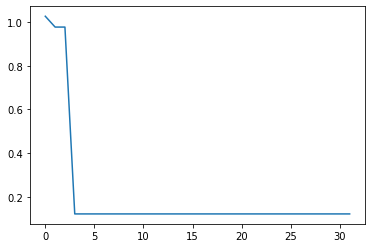

0.01


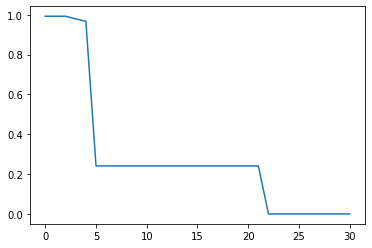

In [294]:
for i in range(3):
  plotpoints = []
  print(1*10**(-i))
  adaptiveSearch([-1.2,0],
                 h=[1*10**2,1*10**2], 
                 n=1*10**3,
                 R=1*10**-i,
                 k=0.9, 
                 func= powFunction,
                 h_diff = 1e-3, 
                 alpha = 1e-3, 
                 eps_singleDim = 1*10**-i,
                 searchAlgorythm='d',
                 max_deep=10)
  plt.plot(plotpoints)
  plt.show()

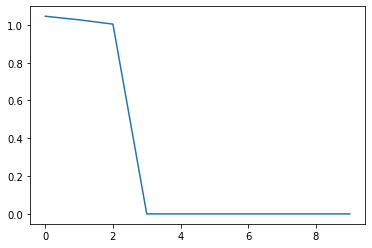

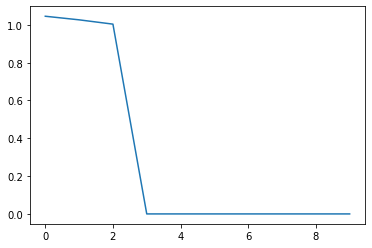

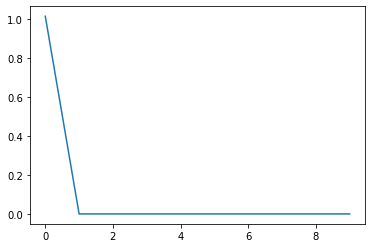

In [291]:
for i in range(3):
  plotpoints = []
  adaptiveSearch([-1.2,0], h=[1e-3,1e-3],
                 n=1*10**5, R=1e-3,
                 k=0.9, func= powFunction,h_diff = 1e-3,
                 alpha = 1*10**-i, eps_singleDim = 1e-2,
                 searchAlgorythm='d', max_deep=10)
  plt.plot(plotpoints)
  plt.show()

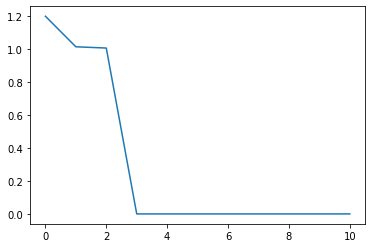

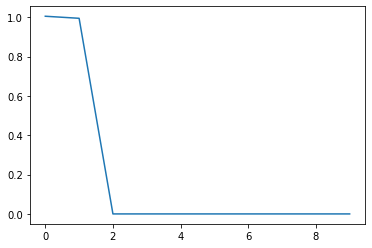

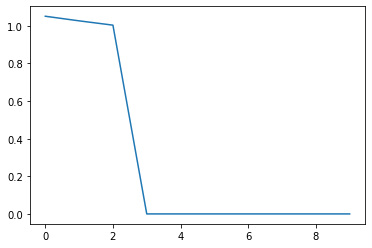

In [285]:
for i in range(3):
  plotpoints = []
  adaptiveSearch([-1.2,0], h=[1*10**-i,1*10**-i],
                 n=1*10**3, R=1e-8, k=0.9,
                 func= powFunction,h_diff = 1e-3,
                 alpha = 1e-3, eps_singleDim = 1e-2,
                 searchAlgorythm='d', max_deep=10)
  plt.plot(plotpoints)
  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


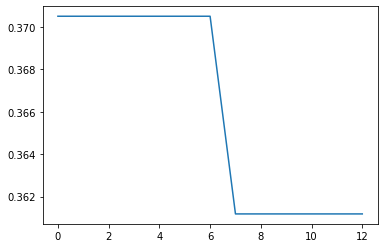

In [343]:
plotpoints = []
adaptiveSearch([-1.2,0], h=[1*10**2,1*10**2],
               n=1*10**3, R=1*10**-3, k=0.9,
               func= powFunction,h_diff = 1e-3,
               alpha = 1e-3, eps_singleDim = 1e-2,
               searchAlgorythm='d', max_deep=10,
               constraint=constraint, useMaxDeep=False)
plt.plot(plotpoints)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


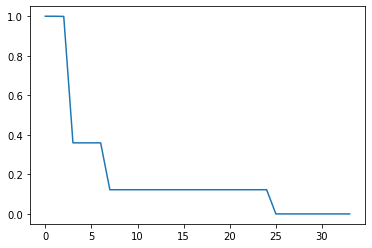

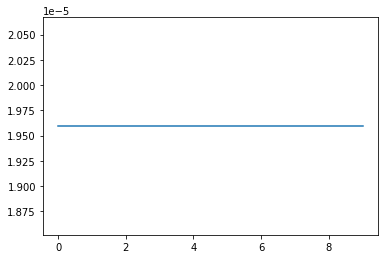

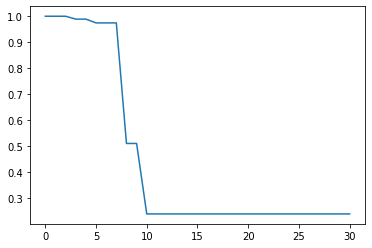

In [282]:
for i in range(3):
  plotpoints = []
  adaptiveSearch([-1.2,0], h=[1*10**2,1*10**2],
                 n=1*10**3, R=1*10**-i,
                 k=0.9, func= powFunction,h_diff = 1e-3,
                 alpha = 1e-3, eps_singleDim = 1e-2,
                 searchAlgorythm='d', max_deep=10)
  plt.plot(plotpoints)
  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


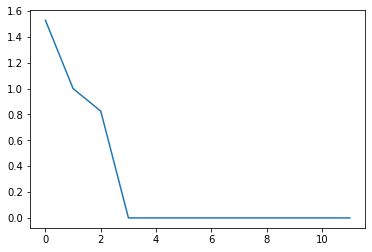

In [303]:
def constraint(x):
  return True

plotpoints = []
adaptiveSearch([-1.2,0], h=[1*10**2,1*10**2],
               n=1*10**3, R=1*10**-3, k=0.9,
               func= powFunction,h_diff = 1e-3, 
               alpha = 1e-3, eps_singleDim = 1e-2,
               searchAlgorythm='d', max_deep=10,
               constraint=constraint, useMaxDeep=True)
plt.plot(plotpoints)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


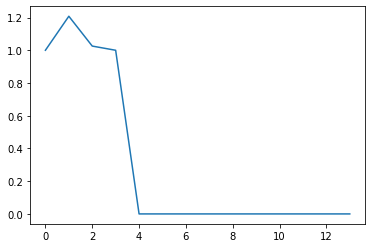

In [309]:
def constraint(x):
  return (norm(x-[0,0]) > 0.05)

plotpoints = []
adaptiveSearch([-1.2,0], h=[1*10**2,1*10**2],
               n=1*10**3, R=1*10**-3, k=0.9,
               func= powFunction,h_diff = 1e-3,
               alpha = 1e-3, eps_singleDim = 1e-2,
               searchAlgorythm='d', max_deep=10,
               constraint=constraint, useMaxDeep=True)
plt.plot(plotpoints)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


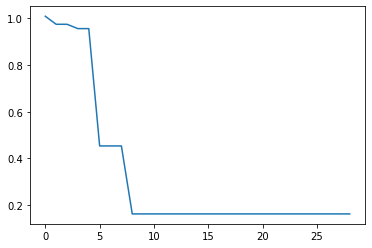

In [322]:
def constraint(x):
  return (x[0] + 2)**2 - x[1]**2 + 4 > 0

plotpoints = []
adaptiveSearch([-1.2,0],
               h=[1*10**2,1*10**2],
               n=1*10**3, R=1*10**-3, 
               k=0.9, func= powFunction,
               h_diff = 1e-3, alpha = 1e-3,
               eps_singleDim = 1e-2, searchAlgorythm='d',
               max_deep=10, constraint=constraint,
               useMaxDeep=True)
plt.plot(plotpoints)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


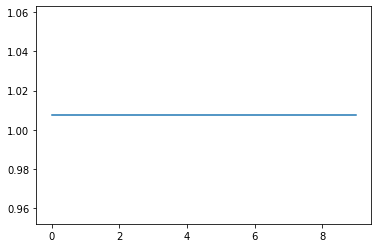

In [334]:
def constraint(x):
  return (x[0] + 2)**2 - x[1]**2 + 4 > 0 and (x[0] + 2)**2 - x[1]**2 - 4 > 0

plotpoints = []
adaptiveSearch([-1.2,0], h=[1*10**2,1*10**2],
               n=1*10**3, R=1*10**-3, k=0.9,
               func= powFunction,h_diff = 1e-3,
               alpha = 1e-3, eps_singleDim = 1e-2,
               searchAlgorythm='d', max_deep=10,
               constraint=constraint, useMaxDeep=True)
plt.plot(plotpoints)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


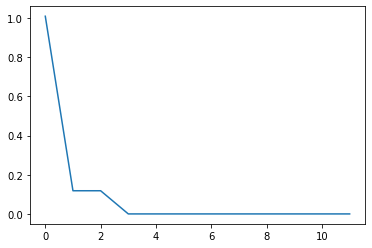

In [336]:
def constraint(x):
  return x[0] <1 and x[0] > -2  

plotpoints = []
adaptiveSearch([-1.2,0], h=[1*10**2,1*10**2],
               n=1*10**3, R=1*10**-3, k=0.9,
               func= powFunction,h_diff = 1e-3,
               alpha = 1e-3, eps_singleDim = 1e-2,
               searchAlgorythm='d', max_deep=10,
               constraint=constraint, useMaxDeep=True)
plt.plot(plotpoints)
plt.show()